# MovieLens 100k - Recommender Systems
설명: 사용자 영화 평가(1~5점)를 기반으로 추천 시스템을 만드는 문제  
MovieLens 100K dataset을 바탕으로 추천 시스템을 설계하고 성능 비교

### Outline (분석 과정)

>데이터 로드 및 전처리  
>- MovieLens 100k 데이터 로드 (users, ratings, movies)  
>- 사용자-영화 평점 행렬 생성 (utility matrix)  
>- 평점 없음(NaN) 0으로 대체
>
>데이터 탐색 및 분할  
>- 평점 분포 시각화  
>- 데이터 sparsity 계산  
>- Train/Test set 분리
>
>추천 시스템 모델링  
>- 협업 필터링 기반 추천 (User-Based CF, Item-Based CF)  
>- 코사인 유사도 기반 유저/아이템 유사도 계산
>
>행렬 분해 기반 추천  
>- Truncated SVD 기반 Matrix Factorization (행렬 보간)
>- ALS(Alternating Least Squares) 기반 추천 (행렬 보간)
>
>딥러닝 기반 추천  
>- AutoEncoder 기반 사용자-영화 재구성 모델 설계 및 학습
>
>성능 평가  
>- RMSE (Root Mean Squared Error)로 예측 성능 비교  
>- Precision@10으로 추천 정확도 비교

### Data Load

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid')


In [127]:
# 사용자 정보
user_cols = ['User_ID', 'Age', 'Sex', 'Occupation', 'ZIP_Code']
users = pd.read_csv('data/ml-100k/u.user', sep='|', names=user_cols, encoding='latin-1')

# 평점 정보
rating_cols = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp']
ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=rating_cols, encoding='latin-1')

# 영화 정보
movie_cols = ['Movie_ID', 'Title', 'Release_Date', 'Video_Release_Date', 'IMDB_URL']
movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=movie_cols, usecols=range(5), encoding='latin-1')

nb_users = users['User_ID'].nunique()
nb_movies = ratings['Movie_ID'].nunique()
print(f"유저 수: {nb_users}, 영화 수: {nb_movies}")

유저 수: 943, 영화 수: 1682


### Data Analysis
`ratings`는 추천의 핵심 정보 (누가 어떤 영화를 몇 점 줬는지)  

`users`는 평점을 준 사람에 대한 정보들이 들어가 있음  

이 둘의 관계를 파악해서 어떤 users들의 정보와 rating을 기반으로 영화 추천 모델을 설계

In [128]:
users

,User_ID,Age,Sex,Occupation,ZIP_Code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [129]:
ratings

,User_ID,Movie_ID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [130]:
movies

,Movie_ID,Title,Release_Date,Video_Release_Date,IMDB_URL
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


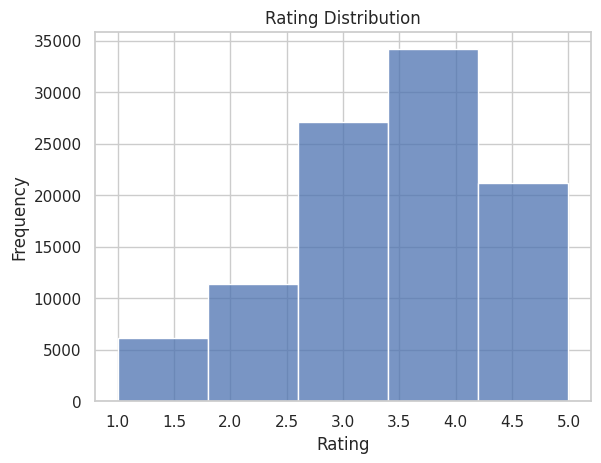

In [131]:
# 평점 분포 확인
sns.histplot(ratings['Rating'], bins=5, kde=False)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

MovieLens 100K는 943명의 사용자, 1682개의 영화에 대한 100,000개의 평점으로 구성.

현재 추천 model을 설계하기 위해선, `User_ID`가 어떤 `Movie_ID`에 얼만큼의 `Rating` 을 주었는지에 대한 관계를 이해해야 함.

그렇기에, `User_ID`, `Movie_ID`, `Rating` 에 대한 utils matrix (user-movie 간 행렬)을 구성

### Data Preprocessing

>추천 시스템의 핵심은 누가 무엇을 얼마나 선호했는가를 파악하는 것
>
>이를 위해 필요한 것은 사용자의 평점 데이터(`ratings`)이며, 이 데이터를 `행렬 형태로 재구성`해야 이후 알고리즘이 작동
>
>그렇기에, 학습을 하기 전에 전처리 과정에서 `User_ID`, `Movie_ID`, `Rating` 에 대한 utils matrix (user-movie 간 행렬)을 구성

In [132]:
# 사용자-영화 평점 행렬 생성 (utility matrix)
ratings_matrix = ratings.pivot(
    index='User_ID', columns='Movie_ID', values='Rating'
)
data_matrix = ratings_matrix.values 
print(f"사용자-영화 평점 행렬: {data_matrix.shape}")
data_matrix

사용자-영화 평점 행렬: (943, 1682)


array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [133]:
total_possible = ratings_matrix.shape[0] * ratings_matrix.shape[1]
actual_rated = ratings_matrix.count().sum()
sparsity = 1 - actual_rated / total_possible
print(f"Sparsity Rate: {sparsity:.4f} (전체의 {sparsity*100:.2f}% 가 비어있음)")

Sparsity Rate: 0.9370 (전체의 93.70% 가 비어있음)


NaN(평점 없음)을 0으로 대체

### Utility Matrix (사용자-영화 간 행렬)

In [134]:
ratings_matrix.fillna(0, inplace=True)
ratings_matrix

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


user의 수 : 943 명 , movie의 수  : 1682 편에 맞게 잘 형성됨.


#### 성능 평가를 위해 dataset 분리

In [135]:
from sklearn.model_selection import train_test_split

# 1) ratings를 train/test로 분리
train_ratings, test_ratings = train_test_split(
    ratings, test_size=0.2, random_state=42
)

all_movies = movies['Movie_ID'].unique()
all_users = ratings['User_ID'].unique()


train_matrix = train_ratings.pivot_table(index='User_ID', columns='Movie_ID', values='Rating', fill_value=0) \
                             .reindex(index=all_users, columns=all_movies, fill_value=0)


test_matrix = test_ratings.pivot(index='User_ID', columns='Movie_ID', values='Rating') \
                           .reindex(index=all_users, columns=all_movies)



In [136]:
train_matrix

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,4.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
936,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
930,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
test_matrix

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Recommender Systems (추천 시스템)

### Collaborative filtering
협업 필터링 기반 추천 (User-User, Item-Item)

협업 필터링은 '나와 비슷한 사용자가 좋아한 영화를 추천해주는 방식'

- `User-Based CF`: 나와 취향이 비슷한 사람들을 찾은 후, 그들이 좋아한 아이템을 추천
- `Item-Based CF`: 내가 좋아한 아이템과 유사한 아이템을 추천


In [138]:
### 2.1 코사인 유사도 기반 유사도 행렬
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(ratings_matrix)
item_similarity = cosine_similarity(ratings_matrix.T)

In [139]:
user_sim_df = pd.DataFrame(user_similarity, 
                           index=ratings_matrix.index, 
                           columns=ratings_matrix.index)
user_sim_df


User_ID,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
User_ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
2,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
3,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
4,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
5,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.118095,0.228583,0.026271,0.030138,0.071459,0.111852,0.107027,0.095898,0.039852,0.071460,...,0.066039,0.431154,0.258021,0.226449,0.432666,1.000000,0.087687,0.180029,0.043264,0.144250
940,0.314072,0.226790,0.161890,0.196858,0.239955,0.352449,0.329925,0.246883,0.120495,0.342961,...,0.327153,0.107024,0.187536,0.181317,0.175158,0.087687,1.000000,0.145152,0.261376,0.241028
941,0.148617,0.161485,0.101243,0.152041,0.139595,0.144446,0.059993,0.146145,0.143245,0.090305,...,0.046952,0.203301,0.288318,0.234211,0.313400,0.180029,0.145152,1.000000,0.101642,0.095120


Utils matrix와 transpose utils matrix 곱을 해보면 1행 1열은 user1, user1 간의 similarity, 1행 2열은 user1, user2 간의 similarity  
`사용자간 유사도가 matrix`로 표현되는 것

In [140]:
item_sim_df = pd.DataFrame(item_similarity, 
                           index=ratings_matrix.columns, 
                           columns=ratings_matrix.columns)
item_sim_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
Movie_ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
2,0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
3,0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
4,0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
5,0.286714,0.318836,0.212957,0.334239,1.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000
1679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000
1680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000


Transpose Utils matrix와 utils matrix 곱을 해보면 1행 1열은 movie1, movie1 간의 similarity, 1행 2열은 movie1, movie2 간의 similarity  
`영화간 유사도를 통한 추천 시스템`로 표현되는 것

user_similarity : 사용자-사용자 간 유사도   (943 x 943) 

item_similarity : 영화-영화 간 유사도  (1682 x 1682)

ratings_matrix  : 실제 사용자-영화 평점 매트릭스 (943 x 1682)


In [141]:
### 예측 함수 정의 (user-based)
def predict_user_based(ratings, similarity):
    mean_user_rating = ratings.mean(axis=1).reshape(-1, 1)
    ratings_diff = ratings - mean_user_rating
    pred = mean_user_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

### 예측 함수 정의 (item-based)
def predict_item_based(ratings, similarity):
    pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

### 예측
user_pred_cf = predict_user_based(data_matrix, user_similarity)
item_pred_cf = predict_item_based(data_matrix, item_similarity)

# 유틸리티 행렬 복구 (user_id, movie_id 인덱스를 기준으로)
user_ids = ratings_matrix.index
movie_ids = ratings_matrix.columns

# 예측 결과를 데이터프레임으로 변환
user_pred_cf_df = pd.DataFrame(user_pred_cf, index=user_ids, columns=movie_ids)
item_pred_cf_df = pd.DataFrame(item_pred_cf, index=user_ids, columns=movie_ids)

[ratings_matrix]x[item_similarity]=[item_pred_cf_df] 이렇게 행렬곱으로 계산

In [142]:
user_pred_cf_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
1,2.695232,1.028553,0.714744,1.569609,0.729177,0.410094,2.417727,1.675929,1.852264,0.779362,...,0.273778,0.276886,0.273962,0.272745,0.275916,0.270580,0.271118,0.270849,0.276821,0.277672
2,1.814992,0.257962,0.234938,0.574352,0.172646,0.049902,1.491545,0.700534,1.320586,0.333219,...,-0.064676,-0.065240,-0.063865,-0.065092,-0.063198,-0.065860,-0.062492,-0.064176,-0.064774,-0.065632
3,1.234233,0.196659,0.141916,0.441848,0.133938,-0.023772,1.149862,0.508257,0.871339,0.175614,...,-0.092863,-0.093202,-0.087589,-0.089812,-0.091125,-0.090081,-0.081725,-0.085903,-0.091640,-0.093077
4,1.471333,0.218540,0.136274,0.491615,0.128348,-0.060891,1.284300,0.559093,0.917543,0.122948,...,-0.129767,-0.129654,-0.128845,-0.130022,-0.128186,-0.129432,-0.123541,-0.126486,-0.129561,-0.130948
5,2.598075,0.843694,0.421290,1.341758,0.464214,0.075539,2.171684,1.460199,1.406886,0.438881,...,-0.025705,-0.022648,-0.026474,-0.027419,-0.025459,-0.029305,-0.029296,-0.029300,-0.022424,-0.023025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2.349006,0.352433,0.287448,0.679108,0.224922,-0.020502,1.840152,0.820433,1.601940,0.271332,...,-0.113899,-0.114076,-0.110970,-0.112807,-0.110252,-0.116127,-0.115419,-0.115773,-0.112129,-0.113978
940,1.969919,0.521823,0.288604,1.013292,0.312450,0.060764,1.782658,1.166318,1.358052,0.358316,...,-0.044234,-0.041731,-0.044444,-0.045497,-0.042931,-0.046485,-0.044251,-0.045368,-0.042832,-0.043356
941,2.283509,0.278703,0.227229,0.573694,0.117995,-0.079872,1.947805,0.714083,1.252264,0.187618,...,-0.168106,-0.167882,-0.167503,-0.168238,-0.165067,-0.169098,-0.167874,-0.168486,-0.165704,-0.166680


`User-Based CF`: 나와 취향이 비슷한 사람들을 찾은 후, 그들이 좋아한 아이템을 추천

In [143]:
item_pred_cf_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
1,1.215603,1.116938,1.143155,1.152897,1.044358,1.095638,1.203018,1.141049,1.162100,1.110017,...,1.092314,1.184760,0.667585,0.667585,1.303448,0.155240,0.155240,0.155240,1.114205,1.503711
2,0.266254,0.155366,0.216833,0.184680,0.172752,0.247071,0.253118,0.203732,0.280860,0.254480,...,0.332700,0.152221,0.255409,0.255409,0.370405,0.363032,0.363032,0.363032,0.144958,0.116938
3,0.108555,0.080347,0.105074,0.088995,0.090528,0.086766,0.118046,0.089999,0.114122,0.100940,...,0.090431,0.032131,0.307658,0.307658,0.140652,0.596573,0.596573,0.596573,0.090083,0.032300
4,0.099211,0.072787,0.088526,0.075906,0.077852,0.066951,0.099893,0.076670,0.093297,0.071345,...,0.137240,0.073285,0.101259,0.101259,0.162757,0.447674,0.447674,0.447674,0.069636,0.037698
5,0.640354,0.642848,0.555897,0.593990,0.551931,0.334977,0.597601,0.584832,0.513914,0.484530,...,0.521391,0.540090,0.244917,0.244917,0.375427,0.001603,0.001603,0.001603,0.579812,0.553527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.269778,0.175360,0.225120,0.173846,0.198610,0.140186,0.239822,0.186166,0.259113,0.168184,...,0.191193,0.110574,0.340174,0.340174,0.381267,0.045073,0.045073,0.045073,0.163180,0.120504
940,0.475433,0.392582,0.388542,0.443601,0.376049,0.367204,0.477112,0.470834,0.475976,0.416810,...,0.601765,0.571474,0.272066,0.272066,0.557340,0.358028,0.358028,0.358028,0.387879,0.389477
941,0.147588,0.091727,0.124641,0.092246,0.087992,0.079093,0.143604,0.100284,0.124669,0.095406,...,0.076586,0.042795,0.066650,0.066650,0.176995,0.041574,0.041574,0.041574,0.102543,0.086894


`Item-Based CF`: 내가 좋아한 아이템과 유사한 아이템을 추천

### Matrix Factorization (행렬 분해)
>협업 필터링의 한계는 sparsity.  
>
>대부분의 유틸리티 행렬은 비어 있고, 유사도를 계산할 수 없을 만큼 데이터가 적은 경우가 많음.  
>
>이를 해결하기 위해 matrix decomposition을 사용
- `Truncated SVD`: 모든 singularvalues를 다 사용하지 않고 일부만 사용해 표현해서 구현
- `ALS`: 내가 좋아한 아이템과 "유사한 아이템을 추천


### The rank k Truncated SVD

In [144]:
from scipy.sparse.linalg import svds

# 사용자 평균 평점으로 중심화
user_mean = ratings_matrix.values.mean(axis=1).reshape(-1, 1)
R_demeaned = ratings_matrix.values - user_mean

# SVD 분해 (k = 50 latent features)
U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)

# 다시 원래 scale로 복구
svd_preds = np.dot(np.dot(U, sigma), Vt) + user_mean
svd_preds_df = pd.DataFrame(svd_preds, index=ratings_matrix.index, columns=ratings_matrix.columns)
svd_preds = np.clip(svd_preds, 0, 5)


In [145]:
svd_preds_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
1,6.488436,2.959503,1.634987,3.024467,1.656526,1.659506,3.630469,0.240669,1.791518,3.347816,...,0.011976,-0.092017,-0.074553,-0.060985,0.009427,-0.035641,-0.039227,-0.037434,-0.025552,0.023513
2,2.347262,0.129689,-0.098917,0.328828,0.159517,0.481361,0.213002,0.097908,1.892100,0.671000,...,0.003943,-0.026939,-0.035460,-0.029883,-0.027153,-0.015244,-0.008277,-0.011760,0.011639,-0.046924
3,0.291905,-0.263830,-0.151454,-0.179289,0.013462,-0.088309,-0.057624,0.568764,-0.018506,0.280742,...,-0.028964,-0.031622,0.045513,0.026089,-0.021705,0.002282,0.032363,0.017322,-0.006644,-0.009480
4,0.366410,-0.443535,0.041151,-0.007616,0.055373,-0.080352,0.299015,-0.010882,-0.160888,-0.118834,...,0.020069,0.015981,-0.000182,0.005593,0.026634,0.023562,0.036405,0.029984,0.015612,-0.008713
5,4.263488,1.937122,0.052529,1.049350,0.652765,0.002836,1.730461,0.870584,0.341027,0.569055,...,0.019973,-0.053521,-0.017242,-0.007137,-0.038987,0.010338,0.004869,0.007603,-0.020575,0.003330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,1.601615,-0.110491,-0.198045,-0.229476,0.345397,0.152378,-0.133373,1.073894,2.993480,-0.240829,...,0.033564,0.014452,0.067121,0.050841,0.058726,0.014191,0.006006,0.010099,0.053688,-0.014125
940,0.585532,-0.355471,-0.186924,2.170066,0.457680,0.013850,3.113494,2.612028,2.554361,-0.451883,...,-0.016607,0.003067,-0.021431,-0.022870,-0.006169,-0.019979,-0.008443,-0.014211,-0.043621,-0.078814
941,3.118558,-0.041062,0.546047,-0.060874,-0.169393,0.015739,2.338824,0.417505,0.679524,-0.015267,...,-0.009333,-0.006661,-0.040438,-0.024605,0.002486,0.006109,0.004205,0.005157,0.002902,-0.006074


### Alternating Least Squares
ALS는 SVD와 달리 명시적으로 사용자-아이템(movie) 행렬을 두 개의 잠재 행렬로 나눠서 학습하는 방식  
사용자 행렬 𝑈, 𝑉 를 반복적으로 번갈아가며 갱신하면서 전체 행렬을 근사

In [146]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

# implicit 라이브러리는 implicit feedback 기반이기 때문에 평점을 confidence로 처리
# confidence = 1 + alpha * rating
alpha = 15  # 살짝 낮춤
confidence_data = 1 + alpha * ratings_matrix.fillna(0).values
implicit_data = csr_matrix(confidence_data).astype('double')

# ALS 모델 튜닝
als_model = AlternatingLeastSquares(
    factors=100,             
    regularization=0.01,      
    iterations=40,         
    random_state=42
)
als_model.fit(implicit_data)


100%|██████████| 40/40 [00:00<00:00, 61.85it/s]


In [147]:
# user/item factor 얻기
user_factors = als_model.user_factors.to_numpy()
item_factors = als_model.item_factors.to_numpy()

# 예측 (confidence 기반 점수)
als_preds = user_factors @ item_factors.T

# DataFrame 변환
als_preds_df = pd.DataFrame(als_preds, index=ratings_matrix.index, columns=ratings_matrix.columns)
als_preds_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
1,1.000237,1.000044,0.999658,0.999179,1.000010,0.999817,1.000131,0.999531,1.000507,1.000134,...,0.999391,0.999153,0.999445,0.999364,0.999158,0.999352,0.999069,0.998968,0.999256,0.999248
2,1.001350,1.000856,1.000155,0.998505,1.000909,1.001081,0.995858,0.997077,0.998353,1.000749,...,1.000902,1.000357,1.000369,1.000296,1.000554,1.000410,0.999633,1.000161,1.000403,1.000048
3,0.990874,1.000074,1.000546,0.998536,0.998253,0.998828,0.993419,0.997143,0.994633,0.996812,...,1.000835,1.001491,1.000850,1.001008,1.000220,1.000995,1.000745,1.000435,1.000415,1.000610
4,0.988913,0.997342,0.998590,0.996172,0.996224,0.999141,0.990309,0.994559,0.993780,0.993844,...,0.999267,0.999175,0.999136,0.999046,0.999677,0.999809,0.998932,0.999602,0.998913,0.998907
5,0.999822,1.000301,1.000824,1.000021,1.001401,1.000815,0.998581,0.997632,0.997543,0.999110,...,1.001104,1.001335,1.000860,1.000953,1.000877,1.000872,1.000481,1.000625,1.000579,1.000785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.994023,0.999853,0.999487,0.998684,0.998084,1.000033,0.993865,0.996481,1.000482,0.999584,...,1.000049,1.000292,1.000080,0.999828,1.000254,1.000910,0.999799,1.000377,1.000194,0.999938
940,0.996572,1.000424,1.001200,1.000793,1.000456,1.002012,1.000108,1.000312,1.000018,1.000552,...,1.001029,1.000919,1.001465,1.001422,1.000760,1.001247,1.000756,1.000655,1.001154,1.000912
941,1.001131,0.997688,0.996260,0.996323,0.995194,0.997695,1.001168,0.993509,0.994121,0.996383,...,0.999110,0.998674,0.998833,0.998820,0.999290,0.999350,0.998345,0.999584,0.998662,0.998405


### Autoencoder 기반 추천 시스템

In [148]:
## 딥러닝 기반 Autoencoder 추천 시스템
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

data_matrix_torch = torch.FloatTensor(data_matrix / 5.0)

# 사용자 수, 영화 수
nb_users = data_matrix.shape[0]
nb_movies = data_matrix.shape[1]

입력 데이터를 0~1로 나눠서 좀 더 안정적으로 분포를 만들어 학습을 진행

In [149]:
# AutoEncoder 정의
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(nb_movies, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, nb_movies),
            nn.Sigmoid()  # 0~1 범위로 맞춰줌
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 모델, 손실함수, 옵티마이저 설정
ae = AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.001)  # Adam, 0.001

출력의 마지막은 Sigmoid로 출력 (0~1 사이)해서 입력과 크기를 맞춰서 학습 진행

In [150]:
# 학습
nb_epoch = 30
for epoch in range(1, nb_epoch+1):
    train_loss = 0
    s = 0
    ae.train()

    for id_user in range(nb_users):
        input = data_matrix_torch[id_user].unsqueeze(0)  # (1, nb_movies)
        target = input.clone()

        output = ae(input)

        # 평점이 있는 항목만 loss 계산
        mask = target != 0
        loss = criterion(output[mask], target[mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        s += 1

    avg_loss = (train_loss / s) ** 0.5  # RMSE 형태
    print(f"Epoch {epoch:02d} | Train RMSE Loss: {avg_loss:.4f}")


Epoch 01 | Train RMSE Loss: 0.2237
Epoch 02 | Train RMSE Loss: 0.2038
Epoch 03 | Train RMSE Loss: 0.1962
Epoch 04 | Train RMSE Loss: 0.1888
Epoch 05 | Train RMSE Loss: 0.1837
Epoch 06 | Train RMSE Loss: 0.1792
Epoch 07 | Train RMSE Loss: 0.1742
Epoch 08 | Train RMSE Loss: 0.1688
Epoch 09 | Train RMSE Loss: 0.1642
Epoch 10 | Train RMSE Loss: 0.1603
Epoch 11 | Train RMSE Loss: 0.1562
Epoch 12 | Train RMSE Loss: 0.1524
Epoch 13 | Train RMSE Loss: 0.1490
Epoch 14 | Train RMSE Loss: 0.1459
Epoch 15 | Train RMSE Loss: 0.1426
Epoch 16 | Train RMSE Loss: 0.1397
Epoch 17 | Train RMSE Loss: 0.1371
Epoch 18 | Train RMSE Loss: 0.1345
Epoch 19 | Train RMSE Loss: 0.1323
Epoch 20 | Train RMSE Loss: 0.1303
Epoch 21 | Train RMSE Loss: 0.1280
Epoch 22 | Train RMSE Loss: 0.1264
Epoch 23 | Train RMSE Loss: 0.1244
Epoch 24 | Train RMSE Loss: 0.1237
Epoch 25 | Train RMSE Loss: 0.1219
Epoch 26 | Train RMSE Loss: 0.1203
Epoch 27 | Train RMSE Loss: 0.1188
Epoch 28 | Train RMSE Loss: 0.1180
Epoch 29 | Train RMS

0인 데이터(=평점 없는 영화)는 학습 대상이 아니고, 평점이 있는 영화만 가지고 reconstruction loss를 계산해야 함

mask를 씌워서 0이 아닌 것만 학습을 진행

In [151]:
# 예측
ae.eval()
predict_ae = np.zeros((nb_users, nb_movies))
with torch.no_grad():
    for id_user in range(nb_users):
        input = data_matrix_torch[id_user].unsqueeze(0)
        output = ae(input)
        predict_ae[id_user] = (output.squeeze(0).numpy()) * 5  # 5 곱해서 원래 스케일 복구

# 결과 DataFrame
ae_preds_df = pd.DataFrame(predict_ae, index=ratings_matrix.index, columns=ratings_matrix.columns)


처음에 5를 나눴으므로 5를 곱해서 복원

In [152]:
ae_preds_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
1,3.616495,3.544199,3.374648,3.737713,2.893620,3.981192,4.263648,3.788944,4.103121,4.489270,...,2.705303,3.810777,2.902347,2.168603,3.317559,1.871475,2.772157,2.120287,3.398159,3.455633
2,4.645926,4.161998,0.883324,4.430903,4.142943,2.676439,3.038690,4.023971,4.928545,2.180868,...,2.788161,4.003970,3.320043,3.517893,2.419327,1.625968,2.862600,3.003886,3.340627,2.513644
3,4.027029,2.808918,3.871062,1.875486,2.961310,0.939934,3.305796,1.769250,3.957798,4.502798,...,2.419353,4.295045,3.436508,3.679841,3.942120,0.683206,3.734825,1.117934,3.413318,4.084617
4,3.254324,3.577733,4.183370,4.525072,4.332204,4.997888,1.342186,1.147888,3.477230,4.997572,...,2.638422,4.452870,1.789086,1.810478,3.980308,0.509147,4.031051,0.886184,1.965281,4.830909
5,3.769340,2.595621,3.745919,3.213102,3.202598,3.569122,4.524537,2.964194,2.456826,4.863489,...,2.523735,3.812767,2.765723,3.126468,3.379610,1.163648,2.941124,1.218394,2.950537,3.011049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,4.315188,4.823120,4.956707,4.474693,4.787184,4.977677,4.337185,4.696541,4.698029,4.874100,...,1.034177,4.197561,4.296637,1.880449,4.076478,1.198586,4.193097,1.932643,3.819646,4.479007
940,3.852338,3.209814,2.004053,3.117714,3.541898,2.969947,3.590858,3.790234,2.981772,2.748955,...,2.741767,3.494679,2.934965,2.425502,2.817066,1.617405,2.809564,2.391796,3.321806,3.029170
941,4.631214,2.754529,0.658596,4.141101,2.318147,4.842556,3.967800,3.232071,4.157379,4.906129,...,3.118047,4.285647,2.486451,2.666012,3.378664,1.263008,2.545541,2.354997,2.625072,4.490049


### Evaluate Metrics
Recall은 추천 모델 시에 평가 지표로 좋지 않은 지표여서 반영 X.

우리가 봐야하는 건 추천 해준 것 중에 좋아하는게 있는게 중요한거지 전체 중에서 좋아하는 것 중에 추천한 수를 보면 안됨.

한마디로, Recall은 전체 수를 기준으로 하니까 현실성 없음.(추가로 user 마다 좋아하는 영화 기준이 달라서 비교가 애매함)


RMSE 평가 함수

In [153]:
from sklearn.metrics import mean_squared_error

# 평가 대상 평점만 추출
ground_truth = ratings_matrix.values

def get_rmse(pred_matrix, true_matrix):
    pred = pred_matrix[true_matrix.nonzero()]
    actual = true_matrix[true_matrix.nonzero()]
    return np.sqrt(mean_squared_error(actual, pred))

Precision@k 함수

In [154]:
def precision_at_k(pred_matrix, true_matrix, k=10):
    precisions = []
    for i in range(pred_matrix.shape[0]):
        pred_row = pred_matrix[i]
        true_row = true_matrix[i]

        # 평점이 아예 없는 유저는 스킵
        if np.sum(true_row) == 0:
            continue

        # 상위 k개 예측
        top_k_items = pred_row.argsort()[::-1][:k]

        # 실제 좋아한 영화 (평점 4 이상)
        relevant_items = np.where(true_row >= 4)[0]

        if len(relevant_items) == 0:
            continue  # 좋아한 영화가 없는 경우 스킵

        hit_count = len(set(top_k_items) & set(relevant_items))
        precisions.append(hit_count / k)

    if len(precisions) == 0:
        return 0.0  # 모든 유저가 스킵됐으면 0 리턴
    return np.mean(precisions)


#### 한 번에 평가
단, ALS는 `평점 예측` 모델이 아니라, `좋아할 것 같은 정도(confidence)`를 점수로 내는 모델이라서 ALS의 RMS 점수는 무시해야 함.


In [155]:
print("🔹 RMSE Scores")
print(f"User-Based CF : {get_rmse(user_pred_cf_df.values, ground_truth):.4f}")
print(f"Item-Based CF : {get_rmse(item_pred_cf_df.values, ground_truth):.4f}")
print(f"SVD           : {get_rmse(svd_preds_df.values, ground_truth):.4f}")
print(f"ALS           : {get_rmse(als_preds_df.values, ground_truth):.4f}")
print(f"AutoEncoder   : {get_rmse(ae_preds_df.values, ground_truth):.4f}")

print("\n🔹 Precision@10 Scores")
print(f"User-Based CF : {precision_at_k(user_pred_cf_df.values, ground_truth):.4f}")
print(f"Item-Based CF : {precision_at_k(item_pred_cf_df.values, ground_truth):.4f}")
print(f"SVD           : {precision_at_k(svd_preds_df.values, ground_truth):.4f}")
print(f"ALS           : {precision_at_k(als_preds_df.values, ground_truth):.4f}")
print(f"AutoEncoder   : {precision_at_k(ae_preds_df.values, ground_truth):.4f}")


🔹 RMSE Scores
User-Based CF : 2.6911
Item-Based CF : 2.9502
SVD           : 1.8533
ALS           : 2.7688
AutoEncoder   : 0.7413

🔹 Precision@10 Scores
User-Based CF : 0.5237
Item-Based CF : 0.1597
SVD           : 0.8001
ALS           : 0.2315
AutoEncoder   : 0.0378


> SVD 기반 추천 모델로 실험 진행하는 게 가장 안전. (비록 RMSE는 Autoencoder가 가장 낮지만, Precision을 보면 성능이 가장 좋음)
>
> ALS는 추가 튜닝(regularization 더 낮추기, factor 수 늘리기)하면 Precision을 성능을 올릴 수는 있음.  
>
> AE는 RMSE는 가장 낮지만, 추천은 잘못하므로 reconsturction만 잘함. 추천 모델용으론 한계가 뚜렷함 (다른 목적 - 예를 들면 이상탐지 용도로 쓰는 게 더 맞음)  